In [1]:
from data_2c_generators import get_iterator, get_dataset
from classifiers import theme_classifier, personal_classifier
import torch
import torch.nn as nn
from torchtext.vocab import GloVe 
GLOVE_EMBEDDING = GloVe(name="6B", dim=300)

In [2]:
(train_dataset, val_dataset, test_dataset, \
     review_text_FIELD, theme_FIELD, perspective_FIELD) = get_dataset(vectors = GLOVE_EMBEDDING)

In [3]:
batch_size = 20
train_iter = get_iterator(train_dataset, batch_size, train=True, shuffle=True, repeat=False)
val_iter = get_iterator(val_dataset, batch_size, train=False, shuffle=True, repeat=False)
test_iter = get_iterator(test_dataset, batch_size, train=False, shuffle=True, repeat=False)

In [4]:
from utils_fns import evaluate_2c

In [5]:
from baseline_2_model import BaseModel, repackage_hidden
with open('./no-teacher-forcing/model_ppl_2c__61.58480131769885.model', 'rb') as file:
    model = torch.load(file)
    model.eval()

In [6]:
#learning_rate = 0.001
#criterion = nn.CrossEntropyLoss(reduction='mean',
#                       ignore_index=train_dataset.fields["review_text"].vocab.stoi['<pad>']).cuda()
#evaluate_2c(model, test_iter, criterion)

def criterion(predictions, targets):
    c = nn.CrossEntropyLoss(reduction='none',
                           ignore_index=train_dataset.fields["review_text"].vocab.stoi['<pad>']).cuda()
    out = c(predictions, targets)
    out = out.mean()
    return out

#evaluate_2c(model, test_iter, criterion)

In [7]:
import numpy as np
np.exp(4.1639207230429465)

64.32322239515557

In [8]:
def transtaltion2string(raw_translations, target_vocab = review_text_FIELD, max_words=30000):
    string_translations = []
    for raw_sentence in raw_translations:
        string_sentence = []
        for i, word_idx in enumerate(raw_sentence):
            if i == max_words: break
            word = target_vocab.vocab.itos[word_idx]
            #if word == '<eos>':
            #    break
            if word != '<sos>':
                string_sentence.append(word)
        string_translations.append(string_sentence)

    return string_translations

In [9]:
from collections import Counter

In [10]:
first_words = []
selected_labels = [[],[]]
lens = []
if True:
    for i, batch in enumerate(test_iter):
        labels_0 = batch.theme.cuda().long() - 1
        labels_1 = batch.perspective.cuda().long() - 1
        batch = batch.review_text.cuda().long()
        if batch.shape[0] > 3:
            selected_labels[0] += labels_0.tolist()
            selected_labels[1] += labels_1.tolist()
            first_words += batch[1,:].tolist()
            lens.append(batch.shape[0]-1)

In [11]:
avg_len = np.mean(lens)
avg_len

22.592261904761905

In [12]:
print(theme_FIELD.vocab.itos[1:])
print(dict(Counter(selected_labels[0])))
print()
print(perspective_FIELD.vocab.itos[1:])
print(dict(Counter(selected_labels[1])))

['other', 'plot', 'acting', 'effect', 'production']
{0: 37614, 3: 2604, 1: 38078, 2: 6593, 4: 2454}

['False', 'True']
{0: 65977, 1: 21366}


In [13]:
# remove duplicates
selected_first_words = list(set(first_words))
print(len(first_words), len(selected_first_words))

# clean for first words that are keywords
first_words_text = transtaltion2string([list(selected_first_words)])[0]
first_words_text = list(map(lambda x: theme_classifier(x) == 'other', first_words_text))
selected_first_words = np.array(selected_first_words)[first_words_text].tolist()
print(len(selected_first_words))

# clean for first words that are keywords perspective
first_words_text = transtaltion2string([list(selected_first_words)])[0]
first_words_text = list(map(lambda x: personal_classifier(x) == False, first_words_text))
selected_first_words = np.array(selected_first_words)[first_words_text].tolist()
print(len(selected_first_words))

87343 4519
4481
4476


In [14]:
#test_list = list(test_iter)

In [15]:
vocab_size = 12304

In [16]:
import numpy as np

In [17]:
BOS_WORD = '<sos>'
EOS_WORD = '<eos>'

In [18]:
def generate_next_n_words(self, first_word, labels, max_len = 3, # ngram=3
                            target_vocab = review_text_FIELD, top_k = 10):
    self.eval()
    with torch.no_grad():      

        #labels_0 = batch.theme.cuda().long() - 1
        #labels_1 = batch.perspective.cuda().long() - 1
        #labels = (labels_0, labels_1)
        #labels = torch.tensor([label]).cuda().long()
        labels = [torch.tensor([label]).cuda().long() for label in labels]

        source = torch.tensor([first_word]).unsqueeze(1).cuda().long()
        
        eos_idx = target_vocab.vocab.stoi[EOS_WORD]
        y_hat = source[:1,:]
        y_hat = y_hat.unsqueeze(-1)

        prediction_idxs = [[y_hat[0]]]
        prediction_probs = [0]

        next_hidden = [None]
        
        for t in range(max_len):
            current_idxs = []
            current_probs = []
            current_hidd = [] 

            for k in range(y_hat.shape[-1]):
                y_hat_k = y_hat[:,:,k]
                current_hidd_k = next_hidden[k]
                output, hidden = self(y_hat_k, labels, current_hidd_k)
                current_hidd += [hidden]*top_k
                top_probs, top_idx = output.topk(top_k, -1)
                current_idxs.append(top_idx.squeeze(0).squeeze(0))
                current_probs.append(top_probs.squeeze(0).squeeze(0))
            current_idxs = torch.cat(current_idxs)
            current_probs = torch.cat(current_probs)

            next_args = torch.sort(current_probs, -1, True)[1][:top_k] 

            next_idxs, next_probs, next_hidden = [], [], []
            tmp_pred_idxs, tmp_pred_probs = [], []
            for idx in next_args:
                chain_head = idx//top_k

                next_idx = current_idxs[idx].int()
                next_prob = current_probs[idx]
                sentence_so_far = prediction_idxs[chain_head]
                
                if len(sentence_so_far)>0 and sentence_so_far[-1] == eos_idx:
                    tmp_pred_idxs.append(sentence_so_far + [eos_idx])
                    tmp_pred_probs.append(prediction_probs[chain_head])
                else:
                    tmp_pred_idxs.append(sentence_so_far + [next_idx])
                    tmp_pred_probs.append(prediction_probs[chain_head] + next_prob)

                next_idxs.append(next_idx.unsqueeze(0))
                next_hidden.append(current_hidd[idx])

            prediction_idxs = tmp_pred_idxs
            prediction_probs = tmp_pred_probs
            next_idxs = torch.cat(next_idxs)

            y_hat = next_idxs.unsqueeze(0).unsqueeze(0).long()
            
        prediction_probs = torch.tensor(prediction_probs)
        prediction_idxs = torch.tensor(prediction_idxs)
        correct_order = torch.argsort(prediction_probs, descending=True).long()
        
        prediction_idxs = torch.index_select(prediction_idxs, 0, correct_order)

        labels = [l.item() for l in labels]
        return prediction_idxs, labels

In [19]:
import pandas as pd

In [20]:
#review_text_FIELD.vocab.itos
theme_FIELD.vocab.itos

['<unk>', 'other', 'plot', 'acting', 'effect', 'production']

In [21]:
avg_len

22.592261904761905

In [22]:
theme_FIELD.vocab.itos

['<unk>', 'other', 'plot', 'acting', 'effect', 'production']

In [37]:
results = []
for label_0 in theme_FIELD.vocab.itos[1:][::-1]:
    for label_1 in perspective_FIELD.vocab.itos[1:][::-1]:
        labels = (theme_FIELD.vocab.stoi[label_0]-1, perspective_FIELD.vocab.stoi[label_1]-1)
        print(label_0, label_1, labels)
        for wid, word0 in enumerate(selected_first_words):
            if wid % 50 == 0 : print('{}/{}'.format(wid, len(selected_first_words)))
            pred_seqs, labels = generate_next_n_words(model, word0, labels, max_len=20, top_k=10) #int(avg_len)

            for i in range(len(pred_seqs)):
                pred = transtaltion2string(pred_seqs[i:i+1])
                string = ' '.join(pred[0])
                predicted_theme = theme_classifier(string)
                predicted_perspective = personal_classifier(string)
                results.append([i, label_0, label_1,
                                string, predicted_theme, predicted_perspective])
        print()

production True (4, 1)
0/4476
50/4476
100/4476
150/4476
200/4476
250/4476
300/4476
350/4476
400/4476
450/4476
500/4476
550/4476
600/4476
650/4476
700/4476
750/4476
800/4476
850/4476
900/4476
950/4476
1000/4476
1050/4476
1100/4476
1150/4476
1200/4476
1250/4476
1300/4476
1350/4476
1400/4476
1450/4476
1500/4476
1550/4476
1600/4476
1650/4476
1700/4476
1750/4476
1800/4476
1850/4476
1900/4476
1950/4476
2000/4476
2050/4476
2100/4476
2150/4476
2200/4476
2250/4476
2300/4476
2350/4476
2400/4476
2450/4476
2500/4476
2550/4476
2600/4476
2650/4476
2700/4476
2750/4476
2800/4476
2850/4476
2900/4476
2950/4476
3000/4476
3050/4476
3100/4476
3150/4476
3200/4476
3250/4476
3300/4476
3350/4476
3400/4476
3450/4476
3500/4476
3550/4476
3600/4476
3650/4476
3700/4476
3750/4476
3800/4476
3850/4476
3900/4476
3950/4476
4000/4476
4050/4476
4100/4476
4150/4476
4200/4476
4250/4476
4300/4476
4350/4476
4400/4476
4450/4476

production False (4, 0)
0/4476
50/4476
100/4476
150/4476
200/4476
250/4476
300/4476
350/4476
400/44

KeyboardInterrupt: 

In [81]:
DF = pd.DataFrame(results, columns=['i', 'true_theme', 'true_perspective', 'generation', 
                                    'predicted_theme', 'predicted_perspective'])

In [82]:
DF[:3]

,i,true_theme,true_perspective,generation,predicted_theme,predicted_perspective
0,0,production,True,<unk> ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?,other,False
1,1,production,True,<unk> ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? <eos>,other,False
2,2,production,True,<unk> . ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?,other,False


In [83]:
#DF.true_theme = l0s
#DF.true_perspective = [str(x) for x in l1s]
DF.predicted_perspective = DF.predicted_perspective.astype(str)

In [84]:
DF.shape

(179180, 6)

In [93]:
DF = DF[DF.generation.apply(lambda x: x.split()[0] != '<unk>')]
DF.shape

(447500, 6)

In [94]:
#DF.to_csv('DF_2c_20_top10_61.584_nounk_c.csv', index=False)

In [95]:
DFA = pd.read_csv('./DF_2c_20_top10_61.584_nounk_a.csv')
DFB = pd.read_csv('./DF_2c_20_top10_61.584_nounk_b.csv')

In [96]:
DF = pd.concat([DF, DFA, DFB])

In [97]:
DF.predicted_perspective = DF.predicted_perspective.astype(str)
DF.true_perspective = DF.true_perspective.astype(str)

In [98]:
DF.shape

(716090, 6)

In [99]:
DF.drop_duplicates(inplace=True)

In [100]:
DF.shape

(447500, 6)

In [101]:
DF.to_csv('DF_2c_20_top10_61.584_nounk_ALL.csv', index=False)

In [102]:
DF.true_theme.unique(), DF.true_perspective.unique()

(array(['production', 'effect', 'acting', 'other', 'plot'], dtype=object),
 array(['True', 'False'], dtype=object))

In [103]:
DF = DF[DF.i ==0]
DF.shape

(44750, 6)

In [104]:
print('baseline 1c - global acc score')
print('theme', (DF.true_theme == DF.predicted_theme).mean())
print('perspective', (DF.true_perspective == DF.predicted_perspective).mean())

baseline 1c - global acc score
theme 0.7397765363128491
perspective 0.9182122905027933


In [105]:
print('Theme, baseline 1c - acc score per class')
for case in DF.true_theme.unique():
    print(case, (DF[DF.true_theme==case].true_theme == DF[DF.true_theme==case].predicted_theme).mean())

Theme, baseline 1c - acc score per class
production 0.6763128491620112
effect 0.6084916201117319
acting 0.6982122905027933
other 0.9225698324022347
plot 0.7932960893854749


In [106]:
print('Perspective, baseline 1c - acc score per class')
for case in DF.true_perspective.unique():
    print(case, (DF[DF.true_perspective==case].true_perspective == DF[DF.true_perspective==case].predicted_perspective).mean())

Perspective, baseline 1c - acc score per class
True 0.8519329608938547
False 0.9844916201117319


In [107]:
from sklearn.metrics import confusion_matrix

In [108]:
cm_theme = confusion_matrix(DF.true_theme, DF.predicted_theme, labels=DF.true_theme.unique())
print('Theme, baseline 1c - confusion matrix')
print(DF.true_theme.unique())
(cm_theme / cm_theme.sum(-1)).round(2)

Theme, baseline 1c - confusion matrix
['production' 'effect' 'acting' 'other' 'plot']


array([[0.68, 0.  , 0.  , 0.26, 0.06],
       [0.02, 0.61, 0.01, 0.32, 0.05],
       [0.  , 0.  , 0.7 , 0.23, 0.06],
       [0.  , 0.  , 0.01, 0.92, 0.07],
       [0.  , 0.  , 0.  , 0.2 , 0.79]])

In [109]:
cm_perspective = confusion_matrix(DF.true_perspective, DF.predicted_perspective, labels=DF.true_perspective.unique())
print('Perspective, baseline 1c - confusion matrix')
print(DF.true_perspective.unique())
(cm_perspective / cm_perspective.sum(-1)).round(2)

Perspective, baseline 1c - confusion matrix
['True' 'False']


array([[0.85, 0.15],
       [0.02, 0.98]])

In [110]:
DF[:3]

,i,true_theme,true_perspective,generation,predicted_theme,predicted_perspective
10,0,production,True,the only thing i ' ve ever liked about this mo...,production,True
20,0,production,True,", we do not care about the director , but it d...",production,True
30,0,production,True,"and , i do n't care about any of these charact...",production,True


In [111]:
DF['true_labels'] = DF.true_theme + ' - ' + DF.true_perspective
DF['predicted_labels'] = DF.predicted_theme + ' - ' + DF.predicted_perspective

In [112]:
cm_labels = confusion_matrix(DF.true_labels, DF.predicted_labels, labels=DF.true_labels.unique())
print('Labels, baseline 1c - confusion matrix')
print(DF.true_labels.unique())
(cm_labels / cm_labels.sum(-1)).round(2)

Labels, baseline 1c - confusion matrix
['production - True' 'production - False' 'effect - True' 'effect - False'
 'acting - True' 'other - False' 'other - True' 'plot - False'
 'plot - True' 'acting - False']


array([[0.75, 0.02, 0.  , 0.  , 0.  , 0.14, 0.02, 0.01, 0.05, 0.  ],
       [0.01, 0.58, 0.  , 0.  , 0.  , 0.36, 0.  , 0.05, 0.  , 0.  ],
       [0.02, 0.  , 0.66, 0.02, 0.  , 0.16, 0.06, 0.  , 0.07, 0.  ],
       [0.  , 0.02, 0.01, 0.52, 0.  , 0.41, 0.01, 0.02, 0.  , 0.02],
       [0.  , 0.  , 0.  , 0.  , 0.75, 0.1 , 0.04, 0.  , 0.09, 0.01],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.93, 0.02, 0.04, 0.  , 0.01],
       [0.  , 0.  , 0.  , 0.  , 0.01, 0.15, 0.75, 0.  , 0.08, 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.22, 0.  , 0.77, 0.01, 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.09, 0.1 , 0.04, 0.77, 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.01, 0.33, 0.  , 0.03, 0.  , 0.62]])

Normalized confusion matrix


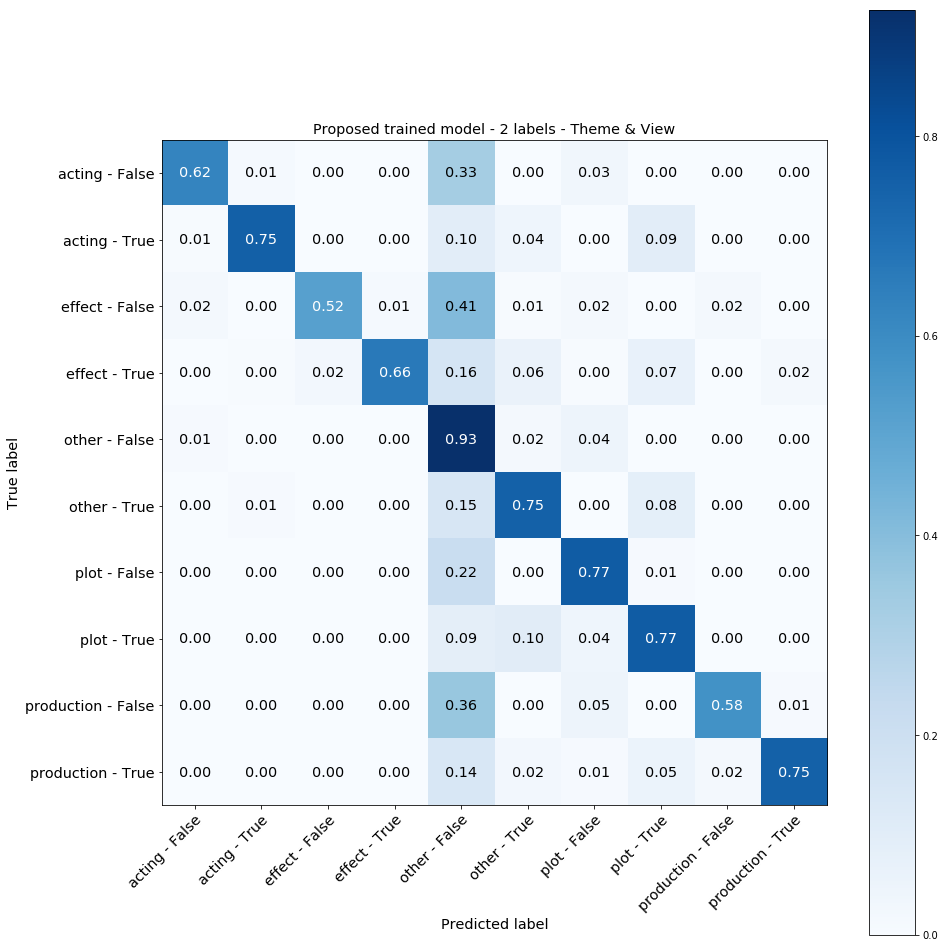

In [114]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

from pylab import rcParams
rcParams['figure.figsize'] = 14, 14


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):

    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = unique_labels(y_true, y_pred) #list(classes) []
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes)

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    
    
    ax.set_xticklabels(ax.get_xticklabels(), fontsize='x-large')
    ax.set_yticklabels(ax.get_yticklabels(), fontsize='x-large')
    ax.set_xlabel(xlabel='Predicted label', fontsize='x-large')
    ax.set_ylabel(ylabel='True label', fontsize='x-large')
    ax.set_title(title, fontsize='x-large')

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black", size='x-large')
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

plot_confusion_matrix(DF.true_labels, DF.predicted_labels, classes=DF.true_labels.unique(), normalize=True,
                      title='Proposed trained model - 2 labels - Theme & View')

#plot_confusion_matrix(DF.true_theme, DF.predicted_theme, classes=DF.true_theme.unique(), normalize=True,
#                      title='Baseline model - 1 label - Theme')

#plot_confusion_matrix(DF.true_perspective, DF.predicted_perspective, classes=DF.true_perspective.unique(), normalize=True,
#                      title='Perspective')

plt.show()

In [51]:
print('baseline 1c - global acc score')
print('labels', (DF.true_labels == DF.predicted_labels).mean())

baseline 1c - global acc score
labels 0.5966927374301676


In [46]:
#DF.to_csv('DF_2c_20_detailed.csv', index=False)